## Initialization
N.B. [X-PSI](https://github.com/xpsi-group/xpsi) installation required to run this notebook. 

In [1]:
%matplotlib inline

import os
import numpy as np
import math

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

import xpsi
from xpsi.utilities.ProjectionTool import plot_projection_general

rc = {"font.family" : "serif",
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'legend.fontsize': 15})

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.2.2               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4.6
Imported nestcheck version: 0.2.1


In [2]:
import _auto_modules_DT.main as main

Parsing configuration file...
x
--main-import-statements
from xpsi.global_imports import gravradius
import math
import numpy as np
--XTI-exposure-time=1.0E+06
--XTI-count-matrix-path=/Users/dc1408/PhD_research/J0437/3c50/j0437_3c50_cl_evt_merged_phase_converted_to_counts.txt
--XTI-number-phase-bins=32
--XTI-arf-path=/Users/dc1408/PhD_research/J0437/3c50/nicer-consim135p-teamonly-array50_arf.txt
--XTI-effective-area-scaling-factor=1.0
--XTI-arf-skiprows=3
--XTI-arf-low-column=0
--XTI-arf-high-column=1
--XTI-arf-area-column=2
--XTI-rmf-path=/Users/dc1408/PhD_research/J0437/3c50/nicer-rmf6s-teamonly-array50_full_matrix.txt
--XTI-rmf-skiprows=3
--XTI-rmf-usecol=-1
--XTI-channels-path=/Users/dc1408/PhD_research/J0437/3c50/nicer-rmf6s-teamonly-array50_full_energy_bounds.txt
--XTI-channel-energies-skiprows=3
--XTI-channel-energies-low-column=1
--XTI-input-bounds
0
1800
--XTI-channel-bounds
30
300
--XTI-energy-independent-effective-area-scaling-factor-value=1.0
--attenuation-path=/Users/dc1408

### Plotting tools

In [3]:
def veneer(x, y, axes, lw=1.0, length=8, ticksize=18):
    """
    Make the plots a little more aesthetically pleasing.

    Parameters:
        - x (tuple or None): Tuple specifying minor and major tick locations for the x-axis.
                             If None, automatic locators (AutoLocator and AutoMinorLocator) are used.
        - y (tuple or None): Tuple specifying minor and major tick locations for the y-axis.
                             If None, automatic locators (AutoLocator and AutoMinorLocator) are used.
        - axes (matplotlib.axes._subplots.AxesSubplot): The matplotlib axes to customize.
        - lw (float, optional): Line width for tick marks and spines in points. Std is 1.0.
        - length (float, optional): Length of tick marks in points. Std is 8.
        - ticksize (float, optional): Font size for tick labels. Std is 18.
    
    Returns:
        None. This function customizes the appearance of tick marks, tick labels, and spines on a matplotlib axes..
    """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())

    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())

    for tick in axes.xaxis.get_major_ticks():
        tick.label1.set_fontsize(ticksize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label1.set_fontsize(ticksize)

    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    
    plt.setp(list(axes.spines.values()), linewidth=lw, color='black')

In [4]:
def plot_flux():
    """ Plot hot region signals before telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    ax.set_ylabel('Signal [arbitrary normalisation]')
    ax.set_xlabel('Phase [cycles]')

    temp = np.sum(main.photosphere.signal[0][0], axis=0)
    ax.plot(main.hot.phases_in_cycles, temp/np.max(temp), 'o-', color='k', lw=0.25, markersize=1)
    ax.grid(linestyle="-.", color='grey',linewidth=0.7)

    veneer((0.05,0.2), None, ax)

In [5]:
def plot_counts(spot_plt):
    """ Plot hot region signals after telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    ax.set_ylabel('Counts')
    ax.set_xlabel('Phase [cycles]')

    ax.plot(np.linspace(0.0, 1.0, 32), spot_plt, 'o-', color='r', lw=0.5, markersize=2)
    ax.grid(linestyle="-.", color='grey',linewidth=0.7)
    
    veneer((0.05,0.2), None, ax)

### Synthesis setup

In [6]:
class SynthesiseData(main.xpsi.Data):
    """ Custom data container to enable synthesis. """

    def __init__(self, channels, phases, first, last):

        self.channels = channels
        self._phases = phases

        try:
            self._first = int(first)
            self._last = int(last)
        except TypeError:
            raise TypeError('The first and last channels must be integers.')
        if self._first >= self._last:
            raise ValueError('The first channel number must be lower than the '
                             'the last channel number.')

In [7]:
_data = SynthesiseData(main.XTI.instrument.channels, np.linspace(0.0, 1.0, 33), 0, len(main.XTI.instrument.channels) - 1) 

Setting channels for event data...
Channels set.


In [8]:
from xpsi.tools.synthesise import synthesise_exposure as _synthesise

In [9]:
bkg = np.zeros((270, 33))

def synthesise(self,
               exposure_time,
               require_background_counts=np.sum(bkg),
               name='synthetic',
               directory='./',
               **kwargs):
    
    self._expected_counts, synthetic, _= _synthesise(exposure_time,
                                                     self._data.phases,
                                                     self._signals,
                                                     self._phases,
                                                     self._shifts,
                                                     require_background_counts,
                                                     bkg)
    try:
        if not os.path.isdir(directory):
            os.mkdir(directory)
    except OSError:
        print('Cannot create write directory.')
        raise

    self._write(self.expected_counts,
                filename = os.path.join(directory, name+'_expected_hreadable.dat'),
                fmt = '%.8e')
    
def _write(self, counts, filename, fmt):
    """ Write to file in human readable format. """

    rows = len(self._data.phases) - 1
    rows *= len(self._data.channels)

    phases = np.arange(0, 32)
    array = np.zeros((rows, 3))

    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            array[i*len(phases) + j,:] = self._data.channels[i], phases[j], counts[i,j]

    np.savetxt(filename, array, fmt=['%-3u', '%-3u', "%-3.3f"])# + [fmt])

In [10]:
main.CustomSignal.synthesise = synthesise
main.CustomSignal._write = _write

In [11]:
signal = main.CustomSignal(data = _data,
                           instrument = main.XTI.instrument,
                           background = None,
                           interstellar = main.interstellar,
                           prefix='NICER')

likelihood = main.xpsi.Likelihood(star = main.star, signals = signal, num_energies = main.args.number_energies, threads=1)

Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].
No data... can synthesise data but cannot evaluate a likelihood function.


In [12]:
# Printing free parameters that need to be fixed to certain values for data generation
likelihood

Free parameters
---------------
cos_inclination: Cosine of Earth inclination to rotation axis.
p__phase_shift: The phase of the hot region, a periodic parameter [cycles].
p__super_colatitude: The colatitude of the centre of the superseding region [radians].
p__super_radius: The angular radius of the (circular) superseding region [radians].
p__super_temperature: log10(superseding region effective temperature [K]).
p__cede_colatitude: The colatitude of the centre of the ceding region [radians].
p__cede_radius: The angular radius of the (circular) ceding region [radians].
p__cede_azimuth: The azimuth of the centre of the ceding region relative to the
centre of the superseding region [radians].
p__cede_temperature: log10(ceding region effective temperature [K]).

## Resolution settings to consider

N.B. The following sections of the notebook have to be re-run for different X-PSI resolution settings. These settings need to be adjusted in the `./_auto_modules_DT/config.ini` file in the same directory as the notebook. The different resolution settings are mentioned in the paper, and are also available for copy-pasting in the `ST_waveforms.ipynb`. The high resolution settings are present by default in the `./_auto_modules_DT/config.ini` file.

## Bithermal

### Synthetic data generation

In [13]:
p = [math.cos(np.radians(137.0)),    #cos_i
     0.0,    # phase
     0.05,    # super colatitude
     0.1,    # super radius
     6.2,    # super temperature
     0.1,    # cede colatitude
     0.15,    # cede radius
     math.pi,    # cede azimuth
     5.8]    # cede temperature   

NICER_kwargs = dict(exposure_time = 1.0E+06,
                    require_background_counts = 0.0,
                    name = 'Bithermal',
                    directory = '../Pulse_profiles_by_diff_codes/XPSI/Hi_res')

likelihood.synthesise(p, force=True, NICER=NICER_kwargs) #SEED=0

In [14]:
LowXPSI_Bithermal = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Low_res/Bithermal_expected_hreadable.dat')
StdXPSI_Bithermal = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Std_res/Bithermal_expected_hreadable.dat')
HiXPSI_Bithermal = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Hi_res/Bithermal_expected_hreadable.dat')
UltraXPSI_Bithermal = np.loadtxt('../Pulse_profiles_by_diff_codes/XPSI/Ultra_res/Bithermal_expected_hreadable.dat')

In [15]:
HiXPSI_Bithermal_plt = np.zeros(32)
for i in range(0,32):
    HiXPSI_Bithermal_plt[i] = np.sum(HiXPSI_Bithermal[:,2][i:33*270:32])

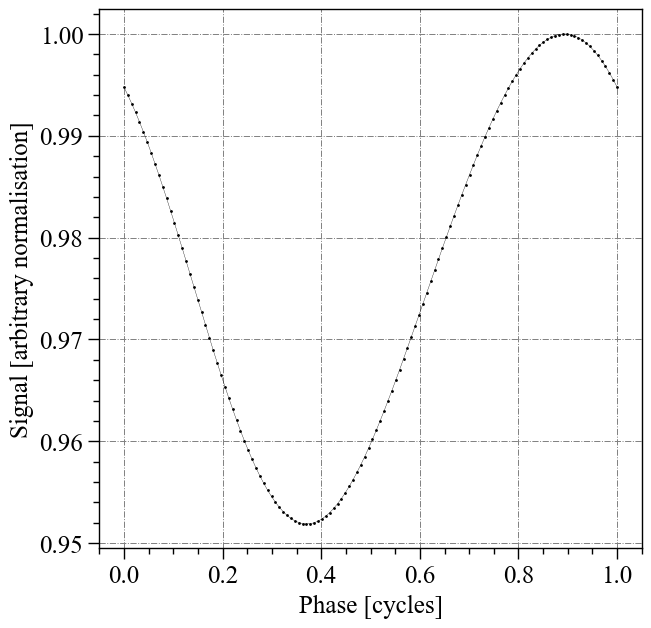

In [16]:
_ = plot_flux() #photosphere signal

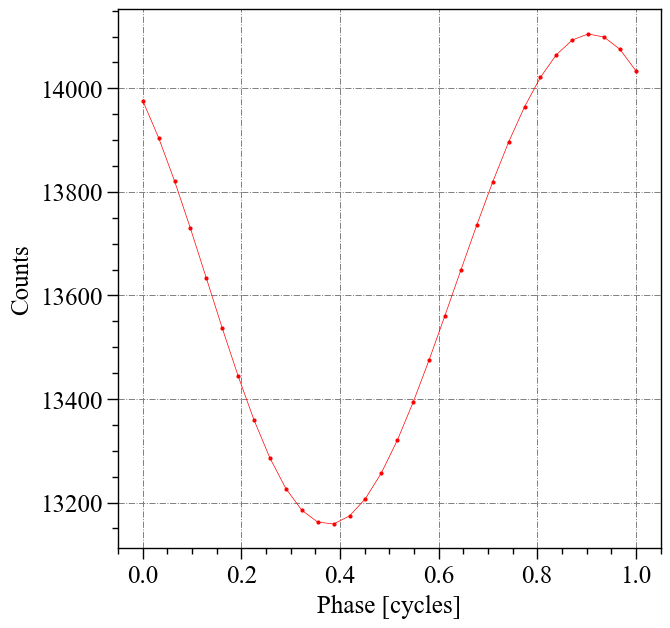

In [17]:
_ = plot_counts(HiXPSI_Bithermal_plt) #registered counts

YOU ARE USING 1 HOT SPOT MODEL


<AxesSubplot: >

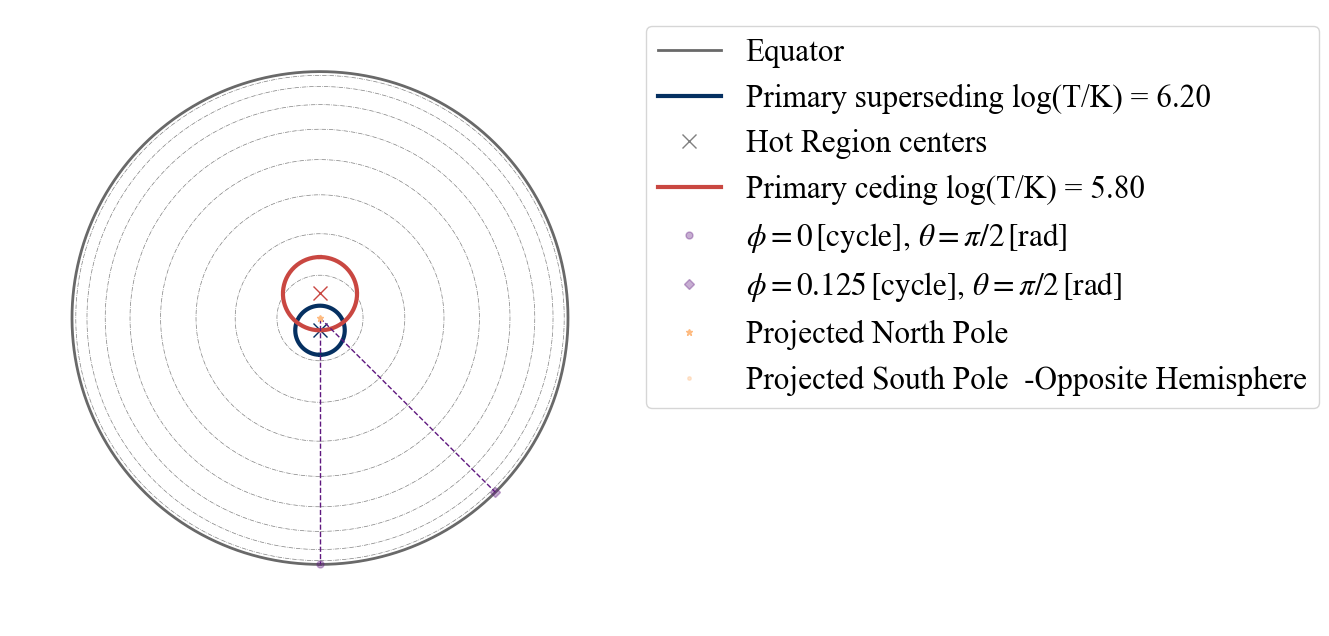

In [18]:
plot_projection_general(likelihood,"PDT",[0,0,1],"NP",
                        SaveFlag = False)

YOU ARE USING 1 HOT SPOT MODEL


<AxesSubplot: >

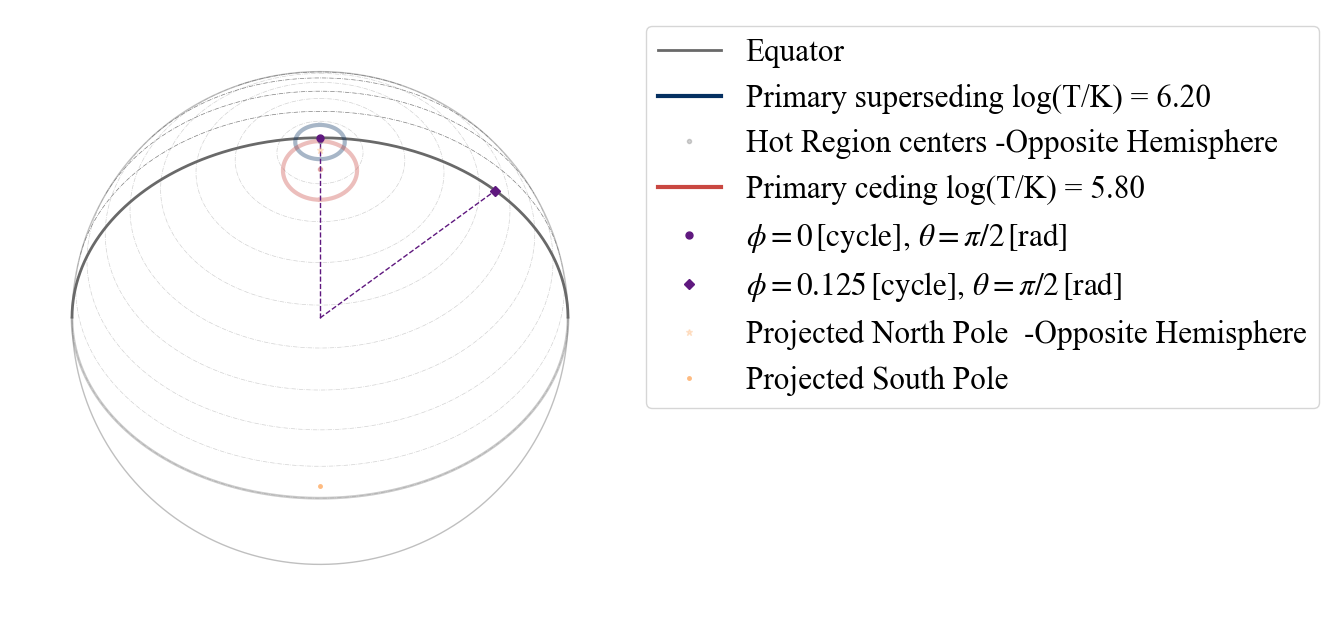

In [19]:
plot_projection_general(likelihood,"PDT","I","NP",
                        SaveFlag = False)